# import

In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [153]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [154]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [155]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [156]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# Предобработка

In [158]:
def date_replace(line):
    '''
    Функция потребуется для вытягивания данных формата даты.
    '''
    # зададим патерн для вытягивания дат из колонки "Reviews"
    pattern = re.compile('\d\d\S\d\d\S\d\d\d\d')
    a = pattern.findall(line)
    return a

def price_mapping(symbol):
    '''
    Функция потребуется для "оцифрования" категориального признака Price Range, где 1- самая низкая цена, 3 - самая высокая.
    '''
    if symbol == '$':
        return 1
    elif symbol == '$$ - $$$':
        return 2
    elif symbol == '$$$$':
        return 3
    
def vegetarian_or_not(row):
    '''
    Функция потребуется для создания нового признака "Наличие вегетарианской кухни".
    '''
    if 'Vegetarian Friendly' not in row:
        return 1
    else:
        return 0

# Анализ признаков

**1. **City****

В данном признаке нет пропусков. Посмотрим распределение признака. 

In [159]:
df['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

Применим метод get_dummies для "оцифрования" городов.

In [160]:
df = pd.get_dummies(df, columns=['City',], dummy_na=True)

**2. Reviews**

In [161]:
df['Reviews'] = df['Reviews'].fillna('0')

In [162]:
# удаляем строки с пустыми отзывами
df.drop(df[df["Reviews"].isnull()].index)
# применим функцию date_replace чтобы избавиться от текстовой части данных и оставить числовую.
df["Reviews"] = df["Reviews"].apply(date_replace)

In [163]:
# разобьем даты на "ранние" и "поздние" чтобы потом сформировать новый признак date_dif "кол-во дней между первым и последним отзывом"
df['data_first'] = df['Reviews'].apply(lambda x: pd.to_datetime(x).min())
df['data_last'] = df['Reviews'].apply(lambda x: pd.to_datetime(x).max())
df['date_dif'] = df['data_last'] - df['data_first']
df['date_dif'].fillna(df['date_dif'].mean(), inplace=True)

**3. Price range**

Посмотрим на распределение признака и пропуски.

In [164]:
df['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [165]:
# применяем функцию, которая "оцифрует" price range
df['Price Range'] = df['Price Range'].apply(price_mapping)

In [166]:
# пропуски заполним средним значением ценового размаха
df['Price Range'].fillna(round(df['Price Range'].mean()), inplace = True)


**4. Cuisine Style**

Пытаемся определить распределение признака 'Cuisine Style'.

In [167]:
df['Cuisine Style'] = df["Cuisine Style"].fillna('0')
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: str(x).strip('[]').split(', '))
df_temp = pd.DataFrame()
df_temp = df.explode('Cuisine Style').dropna()
#df_temp.value_counts()
df_temp['Cuisine Style'].value_counts()

'Vegetarian Friendly'    13928
'European'               11874
'Mediterranean'           7354
0                         6977
'Italian'                 6499
                         ...  
'Latvian'                    1
'Polynesian'                 1
'Burmese'                    1
'Xinjiang'                   1
'Salvadoran'                 1
Name: Cuisine Style, Length: 126, dtype: int64

Выглядит так, что наличие вегетарианской кухни является самым популярным значением, остальные значения этого признака отображают географическую принадлежность кухни, что, на мой взгляд, не является существенным признаком для выбора ресторана, поэтому "оцифровываем" только наличие или отсутствие вегетарианской кухни.

In [168]:
df['Vegeterian?'] = df['Cuisine Style'].apply(vegetarian_or_not)

**5. Number of reviews**

Заполним пропуски нулем, полагая, что пропущенные значения в количестве отзывов ознвчает, что отзывов оставлено не было.

In [169]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

# Определение финального набора данных перед его обучением

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
Restaurant_id        50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          50000 non-null float64
Number of Reviews    50000 non-null float64
Reviews              50000 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
City_Amsterdam       50000 non-null uint8
City_Athens          50000 non-null uint8
City_Barcelona       50000 non-null uint8
City_Berlin          50000 non-null uint8
City_Bratislava      50000 non-null uint8
City_Brussels        50000 non-null uint8
City_Budapest        50000 non-null uint8
City_Copenhagen      50000 non-null uint8
City_Dublin          50000 non-null uint8
City_Edinburgh       50000 non-null uint8
City_Geneva          50000 non-null ui

Итого: нужно избавиться от пяти признаков со строковыми данными.

In [171]:
df = df.select_dtypes(['number', 'timedelta64'])
df

,Ranking,Price Range,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,date_dif,Vegeterian?
0,12963.0,2.0,4.0,0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,123 days 05:14:23.773098,1
1,106.0,2.0,97.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37 days 00:00:00,1
2,810.0,2.0,28.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22 days 00:00:00,1
3,1669.0,3.0,202.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14 days 00:00:00,1
4,37.0,3.0,162.0,0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,15 days 00:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2.0,79.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34 days 00:00:00,1
49996,6341.0,2.0,542.0,1,3.5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,9 days 00:00:00,1
49997,1652.0,2.0,4.0,1,4.5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3127 days 00:00:00,1
49998,641.0,2.0,70.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,23 days 00:00:00,1


Теперь нужно сконвертировать данные типа datetime64, timedelta в числовые, для того чтобы они вошли в набор для обучения.

In [172]:
df['date_dif'] = df['date_dif'].apply(lambda x: x.total_seconds())

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 39 columns):
Ranking              50000 non-null float64
Price Range          50000 non-null float64
Number of Reviews    50000 non-null float64
sample               50000 non-null int64
Rating               50000 non-null float64
City_Amsterdam       50000 non-null uint8
City_Athens          50000 non-null uint8
City_Barcelona       50000 non-null uint8
City_Berlin          50000 non-null uint8
City_Bratislava      50000 non-null uint8
City_Brussels        50000 non-null uint8
City_Budapest        50000 non-null uint8
City_Copenhagen      50000 non-null uint8
City_Dublin          50000 non-null uint8
City_Edinburgh       50000 non-null uint8
City_Geneva          50000 non-null uint8
City_Hamburg         50000 non-null uint8
City_Helsinki        50000 non-null uint8
City_Krakow          50000 non-null uint8
City_Lisbon          50000 non-null uint8
City_Ljubljana       50000 non-null uint8
C

# Корреляция числовых переменных

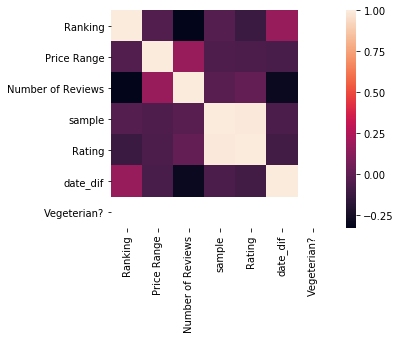

In [174]:
columns_drop = ['City_Amsterdam', 'City_Athens', 'City_Barcelona', 'City_Berlin', 'City_Bratislava', 'City_Brussels', 'City_Budapest', 'City_Copenhagen','City_Dublin' ,'City_Edinburgh', 'City_Geneva', 'City_Hamburg', 'City_Helsinki', 'City_Krakow', 'City_Lisbon', 'City_Ljubljana', 'City_London', 'City_Luxembourg', 'City_Lyon', 'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto', 'City_Oslo', 'City_Paris', 'City_Prague', 'City_Rome', 'City_Stockholm', 'City_Vienna', 'City_Warsaw', 'City_Zurich', 'City_nan']          
corr = df.corr()
sns.heatmap(corr.drop(columns_drop, axis=1).corr(), square=True)

Самой сильной корреляцией с целевой переменной обладает признак "Ranking".

# Запуск модели

In [175]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [176]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [177]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 38), (40000, 38), (40000, 37), (32000, 37), (8000, 37))

In [178]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [179]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [181]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

MAE: 0.21187374999999997


# Submission
Если все устраевает - готовим Submission на кагл

In [182]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,date_dif,Vegeterian?
3965,2971.0,2.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.064606e+07,1
848,3588.0,2.0,73.0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1.728000e+05,1
4901,1117.0,2.0,154.0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1.382400e+06,1
1723,11740.0,2.0,105.0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,7.516800e+06,1
7934,2386.0,1.0,24.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.468800e+07,1
1540,2664.0,2.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.064606e+07,1
1453,2057.0,2.0,98.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,9.417600e+06,1
6557,522.0,2.0,8.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.592000e+05,1
9336,1777.0,2.0,27.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1.382400e+07,1
9850,88.0,2.0,374.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.592000e+05,1


In [183]:
test_data = test_data.drop(['Rating'], axis=1)

In [184]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [185]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [186]:
len(predict_submission)

10000

In [187]:
len(sample_submission['Rating'])

10000

In [188]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.995
1,id_1,4.305
2,id_2,4.455
3,id_3,4.270
4,id_4,4.460
5,id_5,4.450
6,id_6,1.805
7,id_7,3.280
8,id_8,4.085
9,id_9,4.720
